# Task 1: Descriptive Analytics
You have been asked to present to EZ leadership on demand patterns at EZ nationwide. Analyze the data available from this perspective. Create a slide deck for the presentation with data and visuals (no more than title slide + 3 slides). Share both the slide deck and code / files used to create the deck.

## 1. Load libraries

In [32]:
import re
import os
import requests

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import folium

from io import BytesIO
from zipfile import ZipFile

%matplotlib inline
sns.set_style('darkgrid')

Create output folder

In [33]:
write_folder = 'output'
if not os.path.exists(write_folder):
    os.mkdir(write_folder)

## 2. Load data

In [34]:
journeys = pd.read_csv('../data/journeys.csv')
utilization = pd.read_csv('../data/utilization.csv', sep=';', header=1)

## 3. Data Cleansing

In [35]:
for col in [col for col in utilization.columns if 'Time' in col]:
    utilization[col] = pd.to_datetime(utilization[col])

In [36]:
for col in [col for col in journeys.columns if 'Time' in col]:
    journeys[col] = pd.to_datetime(journeys[col])

In [37]:
utilization.columns = [col.lower().replace(' ', '_') for col in utilization.columns]
journeys.columns = [col.lower().replace(' ', '_') for col in journeys.columns]

In [38]:
journeys['trip_sum_trip_price'] = (
    journeys['trip_sum_trip_price'].str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [39]:
journeys['duration'] = (
    journeys['trip_end_at_local_time'] - journeys['trip_start_at_local_time']
)

journeys['duration'] = journeys['duration'].astype('timedelta64[s]')

In [40]:
journeys['creation_to_start'] = (
    journeys['trip_start_at_local_time'] - journeys['trip_created_at_local_time']
)
journeys['creation_to_start'] = journeys['creation_to_start'].astype('timedelta64[s]')

## 4. Merge DFs

In [41]:
cars = journeys.drop_duplicates('car_id_hash')[
    ['car_id_hash', 'car_parking_address_postcode', 'car_parking_address_city']
].reset_index(drop=True)

#### Get geolocation data

In [42]:
response = requests.get("https://download.geonames.org/export/zip/US.zip")
ZipFile(BytesIO(response.content)).extractall('../data/geocodes')

with open('../data/geocodes/readme.txt', 'r') as f:
    names = re.findall('(\w+\s?\w+)\s{4,}\:', f.read())

geocodes = pd.read_csv('../data/geocodes/US.txt', sep='\t', header=None, names=names)
geocodes = geocodes[['postal code', 'admin code1', 'latitude', 'longitude']].copy()

In [43]:
cars = cars.merge(geocodes, left_on='car_parking_address_postcode', right_on='postal code', how='left')

In [44]:
df = utilization.merge(cars, on='car_id_hash', how='inner')

## 5. Create GeoDataFrame
Also create an aggregate version of the same object

In [45]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf.crs = 'EPSG:4326'

In [46]:
geo_ut = gpd.GeoDataFrame(
    gdf.groupby(['postal code'])
    [
        [
            'car_hourly_utilization_sum_utilized_minutes',
            'car_hourly_utilization_sum_available_minutes'
        ]
    ]
    .mean()
    .reset_index()
    .merge(geocodes, on='postal code')
)

In [47]:
geo_ut.geometry = gpd.points_from_xy(
    geo_ut['longitude'], 
    geo_ut['latitude']
)
geo_ut.crs='EPSG:4326'

### Plot map and save to HTML

In [48]:
m = folium.Map(
    location=(geo_ut['latitude'].mean(), geo_ut['longitude'].mean()),
    zoom_start=3
)
for i, point in geo_ut.iterrows():
    circle = folium.CircleMarker(
        location=(point['latitude'], point['longitude']),
        radius=point['car_hourly_utilization_sum_utilized_minutes'],
        popup=f"PostCode: {point['postal code']}\n Avg. car_hourly_utilization_sum_utilized_minutes: {point['car_hourly_utilization_sum_utilized_minutes']}",
        opacity=0.5,
        fill=True,
        color='#008800'
    )
    m.add_child(circle)

In [49]:
m.save(os.path.join(write_folder, 'map.html'), close_file=True)

### Create time-based features and groupings

In [50]:
gdf['hour'] = gdf['car_hourly_utilization_aggregated_at_time'].dt.hour

In [51]:
gb = gdf.groupby(
    ['car_hourly_utilization_aggregated_at_time',
     'car_parking_address_city']
)[['car_hourly_utilization_sum_utilized_minutes', 'car_hourly_utilization_sum_available_minutes']].sum()

In [52]:
gb = gb.reset_index()

In [53]:
gb['day'] = gb['car_hourly_utilization_aggregated_at_time'].dt.day
gb['month'] = gb['car_hourly_utilization_aggregated_at_time'].dt.month
gb['dow'] = gb['car_hourly_utilization_aggregated_at_time'].dt.dayofweek
gb['hour'] = gb['car_hourly_utilization_aggregated_at_time'].dt.hour

In [54]:
gb['delta'] = gb['car_hourly_utilization_sum_available_minutes'] - gb['car_hourly_utilization_sum_utilized_minutes']

In [55]:
gb['dow'] = gb['dow'].map(
    {
        0: 'Mon',
        1: 'Tue',
        2: 'Wen',
        3: 'Thu',
        4: 'Fri',
        5: 'Sat',
        6: 'Sun'
    }
)

## 6. Plot data

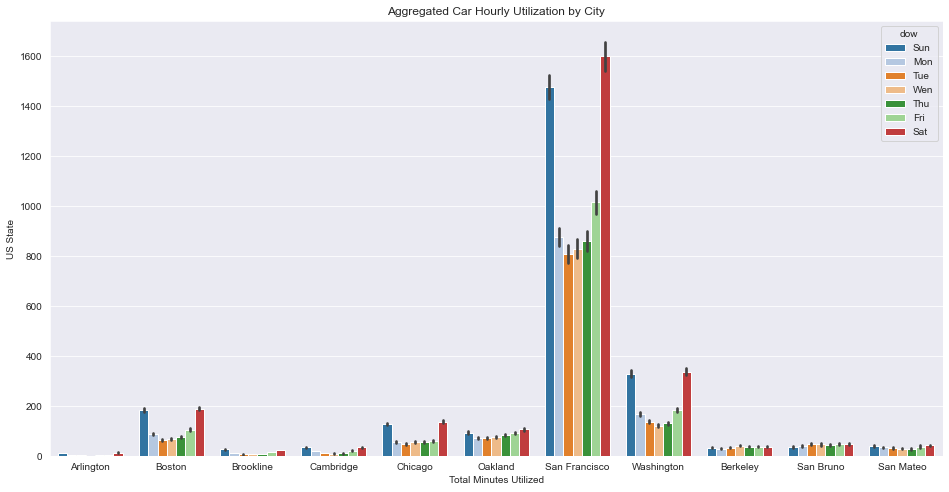

In [56]:
plt.figure(figsize=(16,8))
plt.title('Aggregated Car Hourly Utilization by City')
sns.barplot(
    x='car_parking_address_city',
    y='car_hourly_utilization_sum_utilized_minutes',
    hue='dow',
    data=gb,
    palette='tab20'
);
plt.xlabel('Total Minutes Utilized');
plt.ylabel('US State');
plt.savefig(os.path.join(write_folder, 'Figure 1.svg'))

In [57]:
gb['percentage_used'] = gb['car_hourly_utilization_sum_utilized_minutes'] / gb['car_hourly_utilization_sum_available_minutes']

/Users/francodegiovannini/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


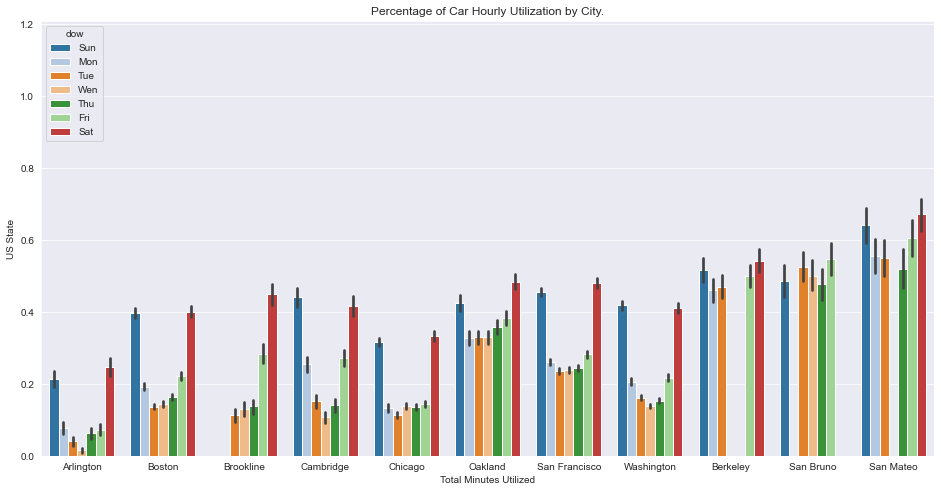

In [58]:
plt.figure(figsize=(16,8))
plt.title('Percentage of Car Hourly Utilization by City.')
sns.barplot(
    x='car_parking_address_city',
    y='percentage_used',
    hue='dow',
    data=gb,
    palette='tab20'
);
plt.xlabel('Total Minutes Utilized')
plt.ylabel('US State')
plt.savefig(os.path.join(write_folder, 'Figure 2.svg'))

In [59]:
gb['week'] = gb['car_hourly_utilization_aggregated_at_time'].dt.isocalendar().week

In [60]:
gb2 = gb.groupby(['week', 'car_parking_address_city'])[['car_hourly_utilization_sum_utilized_minutes', 'car_hourly_utilization_sum_available_minutes']].sum().reset_index()

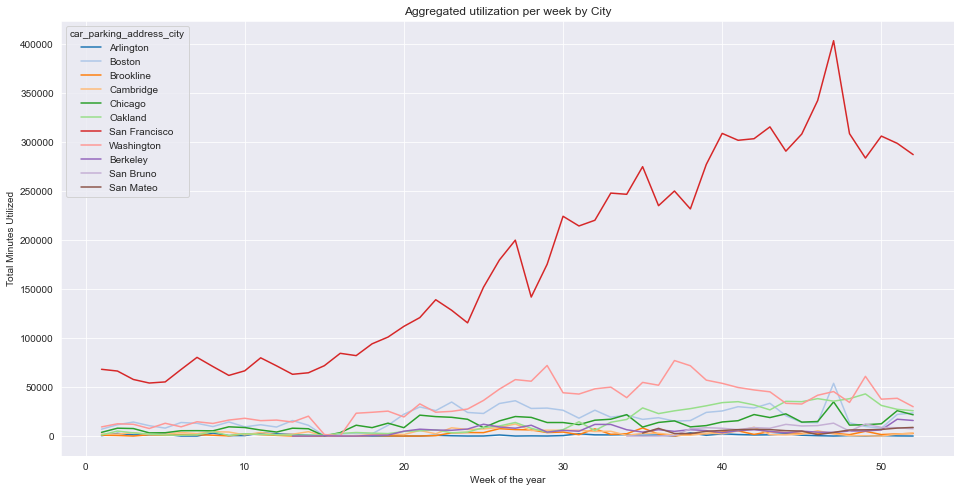

In [61]:
plt.figure(figsize=(16,8))
plt.title('Aggregated utilization per week by City')
sns.lineplot(
    y='car_hourly_utilization_sum_utilized_minutes',
    x='week',
    hue='car_parking_address_city',
    data=gb2,
#    height=10,
    palette='tab20'
);
plt.xlabel('Week of the year');
plt.ylabel('Total Minutes Utilized');
plt.savefig(os.path.join(write_folder, 'Figure 3.svg'))

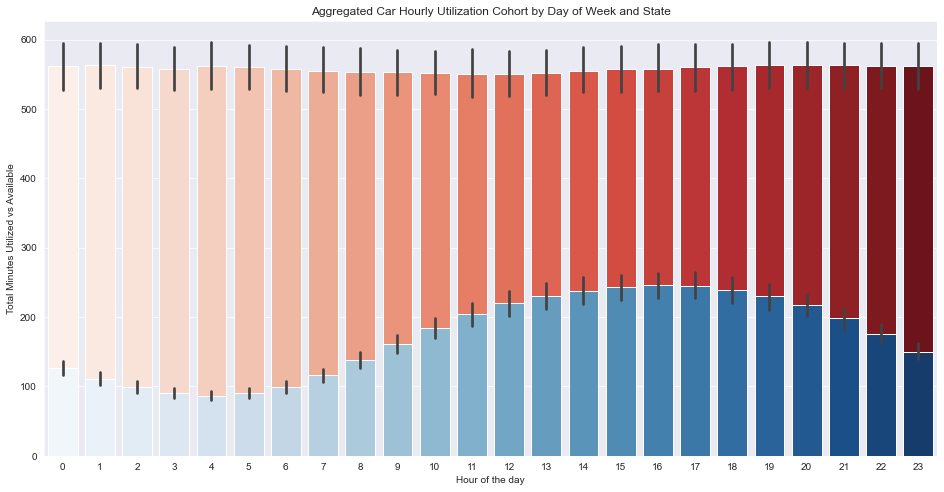

In [62]:
plt.figure(figsize=(16,8))
plt.title('Aggregated Car Hourly Utilization Cohort by Day of Week and State')
sns.barplot(
    x='hour',
    y='car_hourly_utilization_sum_available_minutes',
    data=gb,
    palette='Reds'
);
sns.barplot(
    x='hour',
    y='car_hourly_utilization_sum_utilized_minutes',
    data=gb,
    palette='Blues'
);
plt.xlabel('Hour of the day');
plt.ylabel('Total Minutes Utilized vs Available');
plt.savefig(os.path.join(write_folder, 'Figure 4.svg'))